# Fitting a 1D fault slip model to data from the San Andreas fault

Gareth Funning, University of California, Riverside

To demonstrate some very simple features of nonlinear models, I will use one of the very simplest models out there $-$ the 1D model for strike-slip, as popularized by [Savage and Burford (1973)](https://doi.org/10.1029/JB078i005p00832).

## 1. Dependencies 

If you don't have these things installed, you're probably in the wrong conda environment!

In [ ]:
import numpy as np
import pygmt

## 2. The 1D model for strike-slip

Although it is most commonly known as the Savage and Burford model, the 1D model for strike-slip, or more precisely, for a screw dislocation in an elastic half space, was originally derived by Weertman and Weertman (1964). It makes several simplifying assumptions:

- The fault is vertical
- The fault is infinitely long
- The fault extends infinitely deep, beneath a locking depth, $D$
- The fault is locked above the locking depth
- The fault is stably sliding at a constant, uniform rate, $s$, beneath the locking depth

The model describes how the surface deformation rate, $v$, varies as a function of distance, $x$, from the fault. (There are also expressions for strain rate, $e$, which are effectively the spatial derivative of v, but we won't get into that today.) That relationship is analytical, and simple to evaluate:

$$ v = \frac{s}{\pi} \arctan\left(\frac{x}{D}\right)+v_{shift}$$

where $v_{shift}$ is a shift in velocity to account for the difference between zero in the model and any overall regional motion (e.g. due to plate tectonics).

**Looking at the function that describes the model, what are the parameters? Are any of them linear? Are any of them nonlinear?**

The model is often associated with Savage and Burford, two researchers from the USGS, who in 1973 published their application of the model to EDM (Electronic Distance Measurement, not dance music) data from the San Andreas fault system in California. One of the figures in the paper is something of a classic: 

![Savage and Burford figure](https://raw.githubusercontent.com/geniusinaction/GEO244/refs/heads/main/08_nonlinear_inverse_models/savage_burford_1973.png)

The top panel shows the model geometry (left), the theoretical strain rate distribution (center) and expected displacement (or velocity) profile (right). The lower panel shows the same, but for a fault that is stably sliding from the surface (what you would expect if a fault was creeping at its long-term slip rate).


## 3. Evaluating the 1D model

As the model is simple, we can evaluate it easily in Python. We can try to see what happens when we vary the input parameters.

First, we can make a function to evaluate the model to make things simpler. Then we can use PyGMT to plot it.

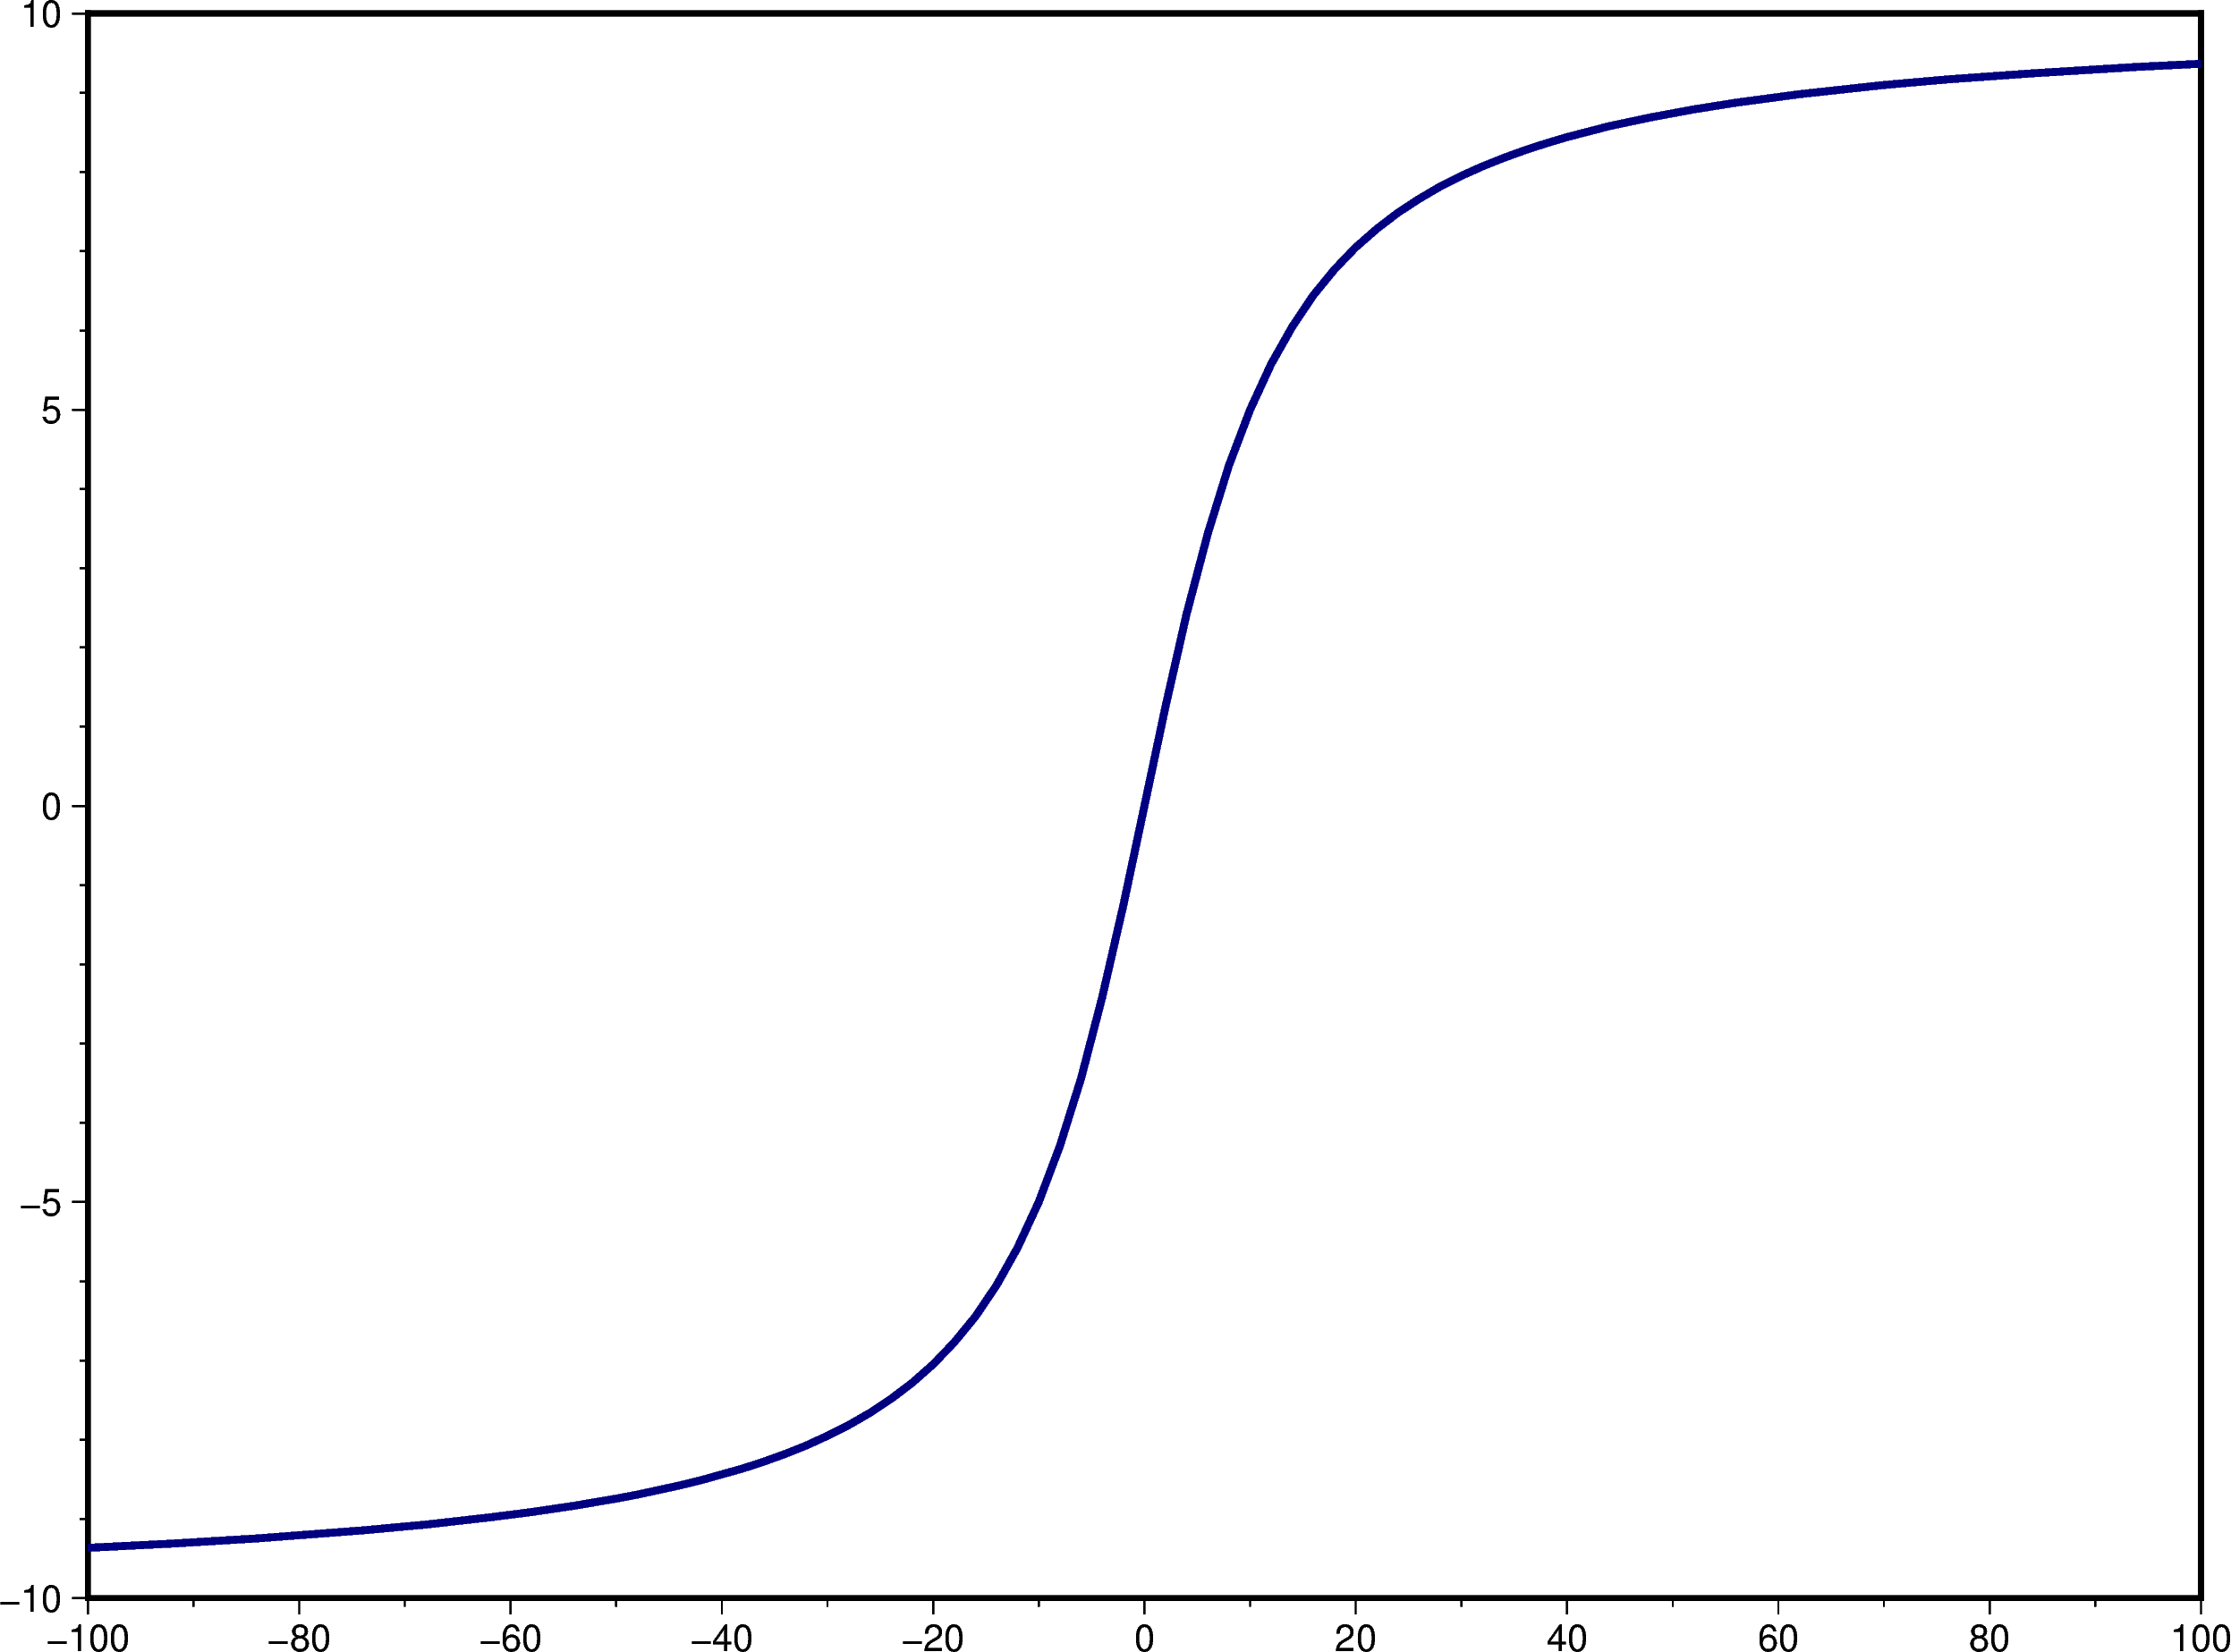

In [66]:
import pygmt

# let's define a function for the 1d model:
def slip1d(s, D, v_shift, x):
    v=(s/np.pi)*np.arctan(x/D)+v_shift
    return v

# let's establish some parameter/input values

s=20        # slip rate in mm/yr, positive left-lateral
D=10        # locking depth in km
v_shift=0   # velocity shift in mm/yr

x=np.linspace(-100,100,101)  # an array of distances in km

# and evaluate it!

v=slip1d(s,D,v_shift,x)

# let's plot it to see what we got

region = [np.min(x), np.max(x), -s/2, s/2]




fig = pygmt.Figure()
fig.basemap(region=region,projection='X20c/15c',frame=True)
#fig.plot(data=gps_data,style='c0.1c',fill='black',error_bar='y')
fig.plot(x=x,y=v,pen='2p,navy')
fig.show()


## 4. Solving for a real slip rate and locking depth

Let's try and get hold of some real GNSS data for the San Andreas! Schmalzle et al. (2006) used campaign GNSS survey data from the 1990s and 2000s to constrain its slip rate. The paper is here: https://doi.org/10.1029/2005JB003843

Table 3 of the paper has the relevant data. Can we load it in somehow? And plot it? Note that the fault-parallel velocities are included with their uncertainties $-$ can we load all of those in?

In [146]:
# a blank code cell for you to contemplate formatting and plotting your data

# !awk -F'/t+' '{print $1 $2}' 'dixon_gnss.txt' > clean_gnss.tmp


 
# !awk -F'\t'+ '{ if ($4=="-") print $1, $2, $3; else print $1, $4, $5 }' 'dixon_gnss.txt' | awk -F' ' '{print $1" "$2" "$4" "$5" "$7}'  > clean_gnss.tmp 

# !paste "clean_gnss.txt" <(awk '{print " "$2, $3}' "dixon_gnss_loc.txt")  > 'clean_gnss_loc.txt'



!awk -F' ' ' { print $2" "$3" "$4" "$5" "$6" "$7 }' 'clean_gnss_loc.txt' > 'clean_gnss_locv2.txt'


Notice anything about the sign of the data? Should we do anything about that, and if so, what?

Next, we should think about how we might perform some kind of grid search to solve for the slip rate and locking depth of the San Andreas. The code snippet below is one way of trying to establish some arrays of values over which to evaluate the model. (I would seriously recommend changing these, they were included to give you some idea of syntax, not because they have the correct values!) 

In [99]:
import pandas as pd
import utm
import numpy as np
import math



datafile=pd.read_csv('clean_gnss_locv2.txt', delimiter=' ', header=None)

vx=datafile[1]
vy=datafile[3]









v1=np.sqrt((vx**2) + (vy**2))
print(v1)

lon=datafile[5]
lat=datafile[6]
th1tmp=[]


pi=4*np.arctan2(1,1)

for idx in range(1,len(datafile),1):
    aztmp=np.arctan2(vx[idx],vy[idx])*180/pi
    if aztmp > 0:
        aztmp+=360
        th1tmp.append(aztmp)
    else:
        th1tmp.append(aztmp)  
        
th1=np.array(th1tmp) 

print(th1)
    


# # set minimum and maximum slip rate bounds, plus a step size
# smin=5
# smax=50
# sstep=5

# # make a range of possible slip rate values
# slip_rates=np.arange(smin,smax+sstep,sstep)

# # set minimum and maximum locking depth bounds, plus a step size
# Dmin=5
# Dmax=25
# Dstep=4

# # make a range of possible locking depth values
# locking_depths=np.arange(Dmin,Dmax+Dstep,Dstep)

0     37.372851
1     16.838646
2     16.900888
3     42.671302
4     47.941631
5     25.608788
6     26.581949
7     17.194476
8     23.942013
9     48.914619
10    46.954127
11    30.121919
12    46.838552
13    41.208252
14    26.706741
15    46.553625
16    20.541908
17    33.329416
18    47.591806
19    37.631104
20    32.681034
21    47.668124
dtype: float64
[-46.92518371 -50.28124063 -41.0090869  -40.60129465 -40.40715467
 -39.19841311 -47.1210964  -41.61366567 -39.02567671 -41.80581124
 -41.0964565  -41.27798499 -42.04922089 -38.15722659 -43.08504899
 -36.08889353 -39.27731149 -39.54352604 -46.50743576 -40.90555082
 -41.68344854]


Next, we should try to calculate the fit of a model to the data. One metric we can use is the total squared misfit, also known as the 'Residual Sum of Squares' or *RSS*:

$$ RSS = \sum_{i=1}^N (v_i - v_i')^2 $$

where $N$ is the number of data points, $v_i'$ are the predicted values of the data from the model, and $v_i$ are the observed data values. In vector/matrix form, this becomes:

$$ RSS = (\bf{v - v'})^T (\bf{v-v'}) $$

If you are able to form an inverse covariance matrix, $\bf{E^{-1}}$, based on the uncertainties of the data, you can use it to estimated the Weighted Residual Sum of Squares (*WRSS*) like so:

$$ WRSS = (\bf{v - v'})^T \bf{E^{-1}}(\bf{v-v'}) $$

**Hint**: The `np.diag` function will allow you to make a diagonal matrix out of a numpy array, which might be useful for making $\bf{E^{-1}}$. 

In [113]:
!awk -F' ' '{ print $7" "$6 }' 'clean_gnss_loc.txt'

35.003 -119.838
36.185 -118.727
35.819 -119.259
34.96 -120.3
34.593 -120.617
35.575 -120.001
35.358 -119.394
35.398 -119.394
35.414 -119.766
34.731 -120.414
34.798 -120.257
35.441 -119.957
34.894 -120.606
35.076 -120.067
35.503 -119.959
34.739 -120.279
35.603 -119.853
35.52 -120.113
34.571 -120.627
35.133 -119.902
35.488 -120.018
34.556 -120.616


In [147]:
# !awk -F' ' '{ print $6" "$7 }' 'clean_gnss_loc.txt'| gmt project -C-119.923742/35.368309 -A50 -Q > clean_gnss_loc_dis.txt

!awk -F' ' '{ print $3" "$4}'  'clean_gnss_loc_dis.txt' | paste clean_gnss_loc_dis.txt > 'clean_gnss_loc_dis2.txt' 



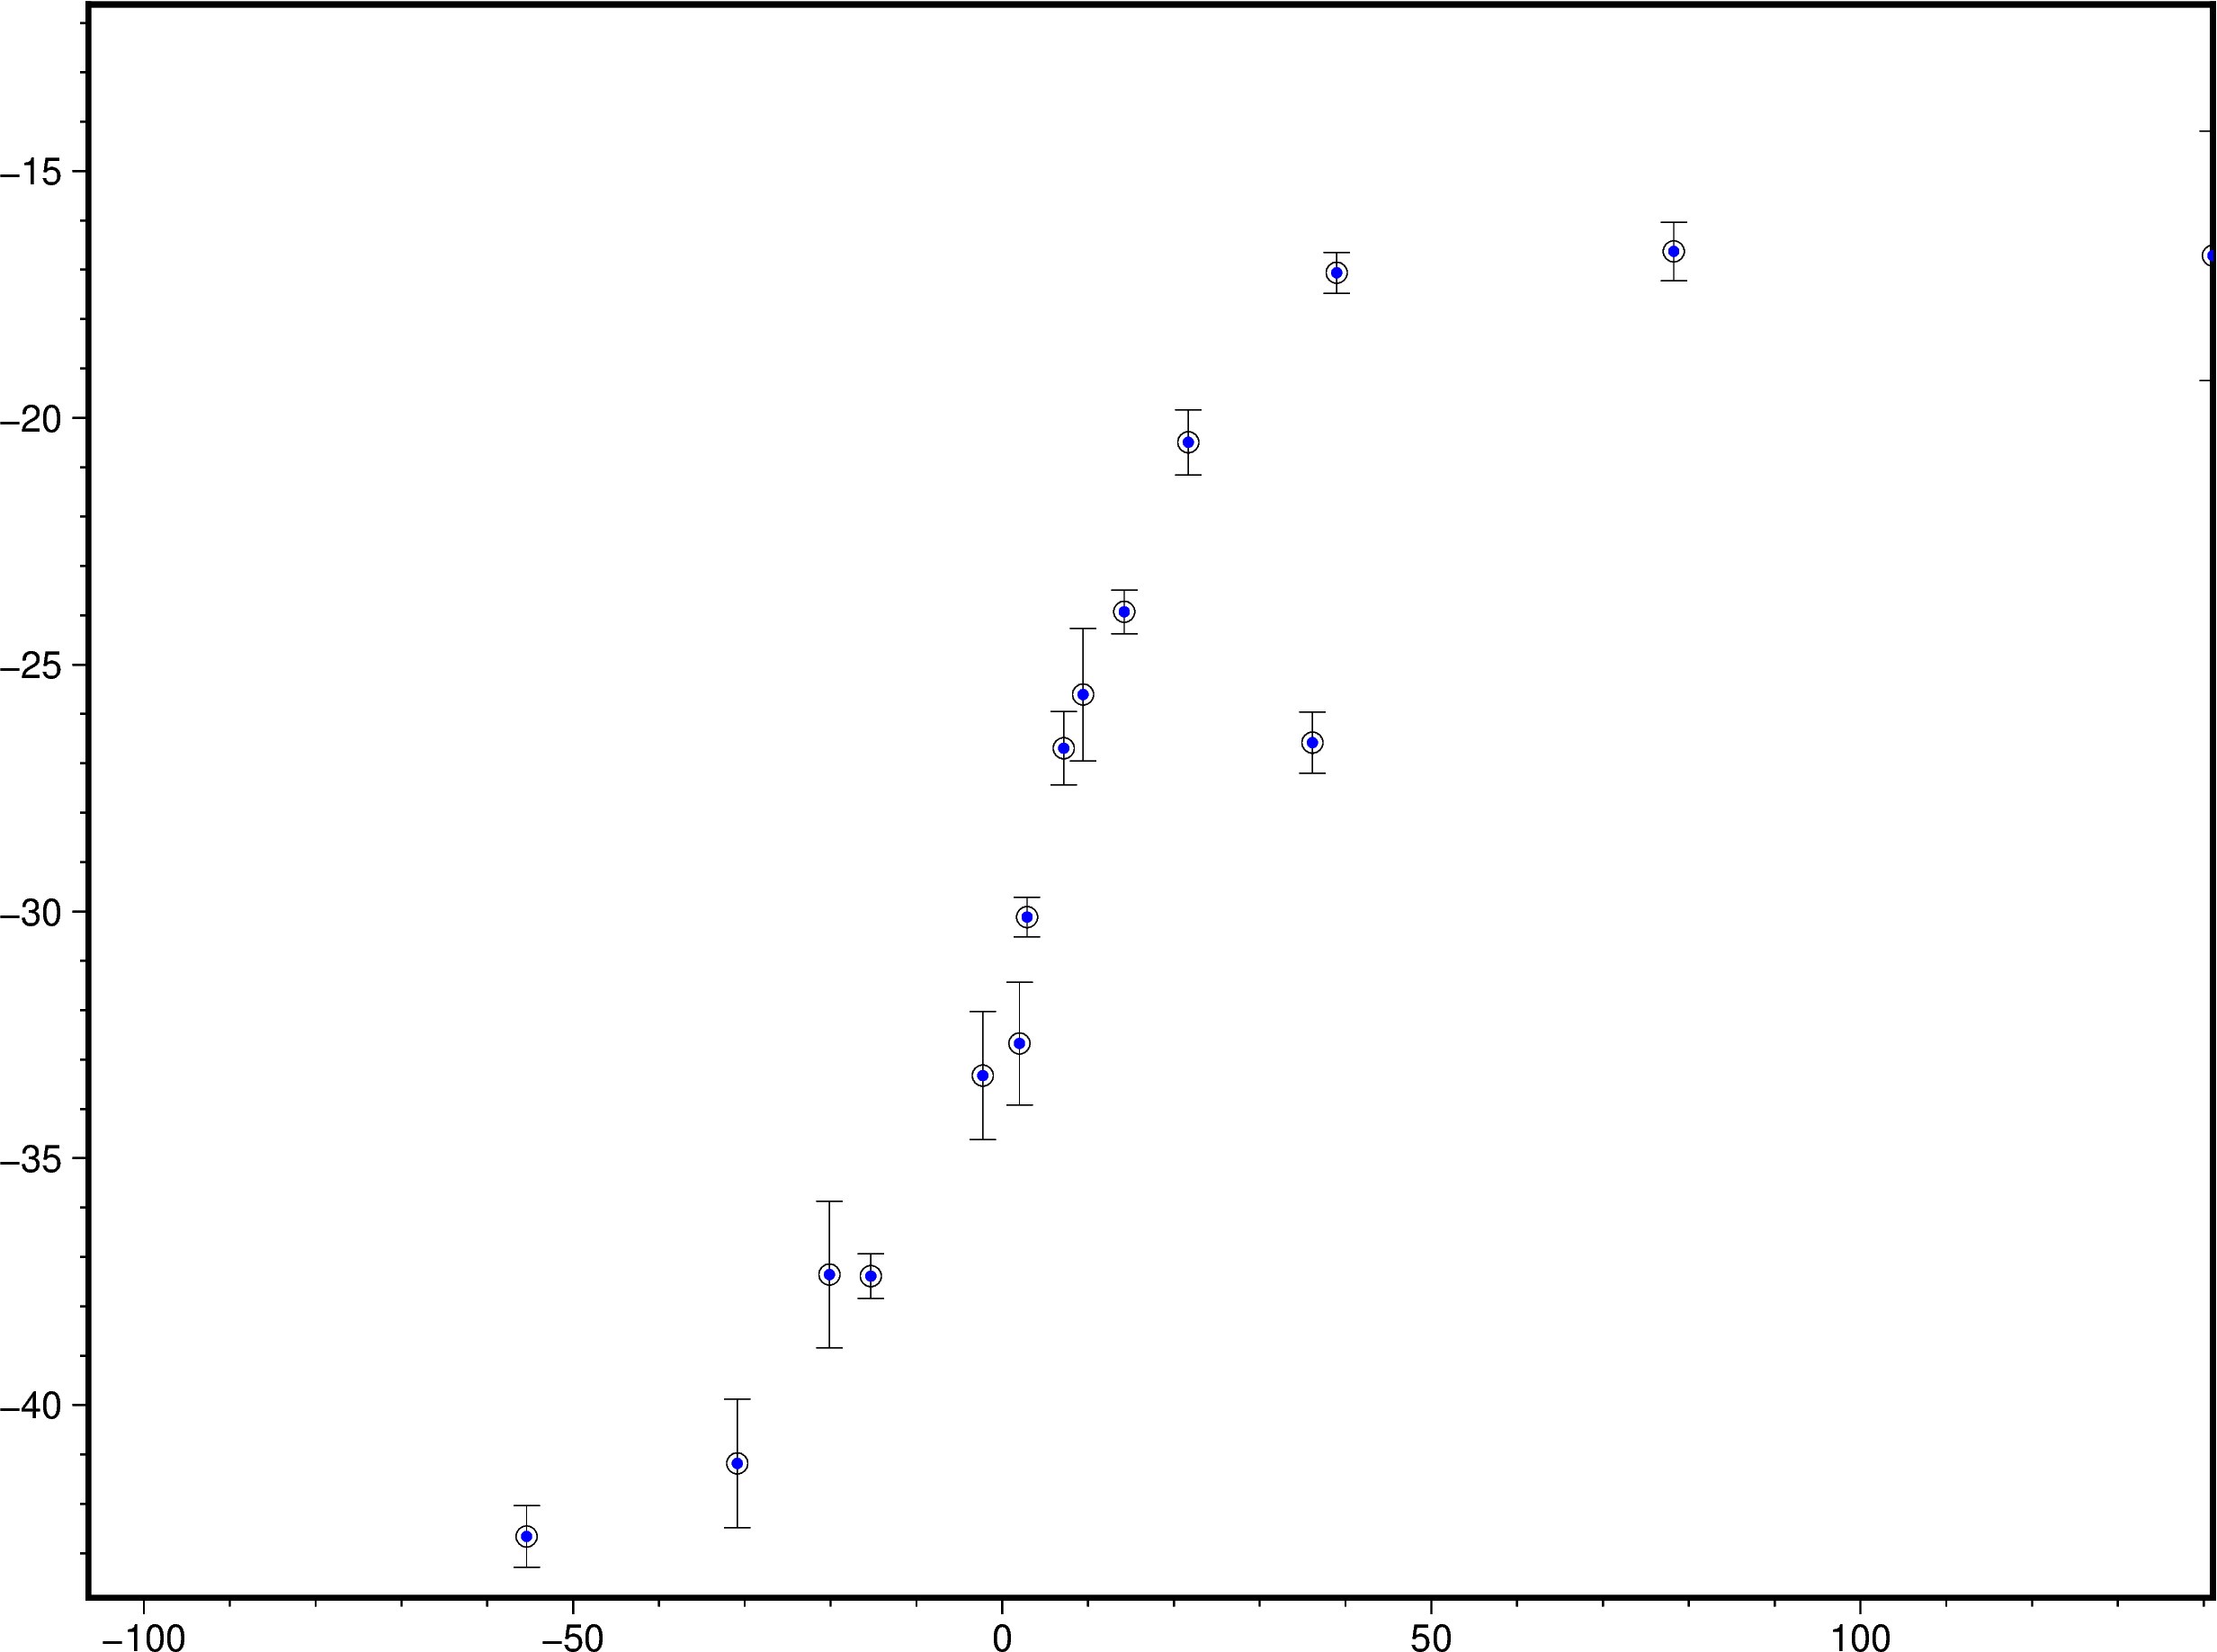

In [192]:

datafile=pd.read_csv('clean_gnss_locv2.txt', delimiter=' ', header=None)

# vx=datafile[1]
# vy=datafile[3]



# set the strike



strike=140
dx=np.sin(np.radians(strike))

dy=np.cos(np.radians(strike))


horiz_gps=np.loadtxt('clean_gnss_locV2.txt')

x_dis=np.loadtxt('clean_gnss_loc_dis2.txt')

# Takes the dot product between the velocity ovector and the strke vector

v_gps=horiz_gps[:,0]*dx + horiz_gps[:,2]*dy








v_gps_error=np.sqrt(dx**2*horiz_gps[:,1]**2 + dy**2*horiz_gps[:,3]**2)








region = [np.min(x_dis[:,2]), np.max(x_dis[:,2]), min(v_gps)+5, max(v_gps)+5]




fig = pygmt.Figure()
fig.basemap(region=region,projection='X20c/15c',frame=True)




#fig.plot(data=gps_data,style='c0.1c',fill='black',error_bar='y')
fig.plot(np.vstack((x_dis[:,2],v_gps)).T, style='c0.2')
fig.plot(np.vstack((x_dis[:,2], v_gps, v_gps_error)).T, style='c0.1',fill='blue', error_bar='y')
fig.plot(x=x,y=v,pen='2p,navy')
fig.show()

In order to use all of this information to model the slip on the San Andreas fault, we want to set up a couple of loops to evaluate all of the combinations of locking depth and slip rate, and then a misfit (penalty) for each of them. Then, the model with the smallest misfit will be the best-fitting model!

The following code snippet will loop through all of your locking depths, as a starting point:

In [189]:
# set minimum and maximum slip rate bounds, plus a step size
smin=20
smax=40
sstep=2

# make a range of possible slip rate values
slip_rates=np.arange(smin,smax+sstep,sstep)
#print(slip_rates)

# set minimum and maximum locking depth bounds, plus a step size
Dmin=10
Dmax=25
Dstep=1

# make a range of possible locking depth values
locking_depths=np.arange(Dmin,Dmax+Dstep,Dstep)
#print(locking_depths)

# set minimum and maximum velocity shift bounds, plus a step size
Vsmin=-35
Vsmax=-28
Vsstep=1

# make a range of possible locking depth values
velocity_shifts=np.arange(Vsmin,Vsmax+Vsstep,Vsstep)
#print(velocity_shifts)

#keep track of the best model
best_s=-9999
best_D=-9999
best_Vs=-9999
best_RSS=1e30

#RSS_array=np.zeros((len(slip_rates),len(locking_depths),len(velocity_shifts)))
#RSS_array=np.empty(((len(slip_rates)-1)(len(locking_depths)-1)(len(velocity_shifts)-1)))
RSS_array=np.empty((len(slip_rates)*len(locking_depths)*len(velocity_shifts)))
#RSS_array=np.empty((0,0))

#c_s=0
#c_D=0
#c_Vs=0

c=0

# loop through your locking depths to show how it is done

for s in slip_rates:
    for D in locking_depths:
#    for s in slip_rates:
        for Vs in velocity_shifts:
            model_v=slip1d(s,D,Vs,x_dis[:,2])
            RSS=np.sum((v_gps-model_v)**2)
#            print(s,D,Vs,RSS)
#            RSS_array[c_s,c_D,c_Vs]=RSS
#            np.append(RSS_array,RSS)
            RSS_array[c]=RSS

            if RSS<best_RSS:
                best_s=s
                best_D=D
                best_Vs=Vs
                best_RSS=RSS

            c+=1
#            c_Vs+=1
#        c_D+=1
#    c_s+=1
print("Best Model: s = {0:f} mm/yr, D = {1:f} km, Vs = {2:f} mm/yr, RSS = {3:f} (mm/yr)^2".format(best_s,best_D,best_Vs,best_RSS))        



#fig.plot(data=gps_data,style='c0.1c',fill='black',error_bar='y')
fig.plot(np.vstack((x_dis[:,2],v_gps)).T, style='c0.2')
fig.plot(np.vstack((x_dis[:,2], v_gps, v_gps_error)).T, style='c0.1',fill='blue', error_bar='y')
fig.plot(x=x,y=v,pen='2p,navy')
fig.show()       
    #print(D)  # mind you, you probably want to evaluate the model here, and then the misfit, not whatever this is
                

array([1.48695262, 2.52997939, 0.5908995 , 0.62248426, 1.88520919,
       1.34222111, 0.62248426, 0.41498951, 0.44405611, 1.34222111,
       1.68551465, 0.4       , 1.3       , 1.3       , 0.73887019,
       1.4       , 0.66079412, 1.3       , 1.88520919, 0.44895155,
       1.24229384, 1.2       ])

Best Model: s = 36.000000 mm/yr, D = 24.000000 km, Vs = -32.000000 mm/yr, RSS = 94.260506 (mm/yr)^2


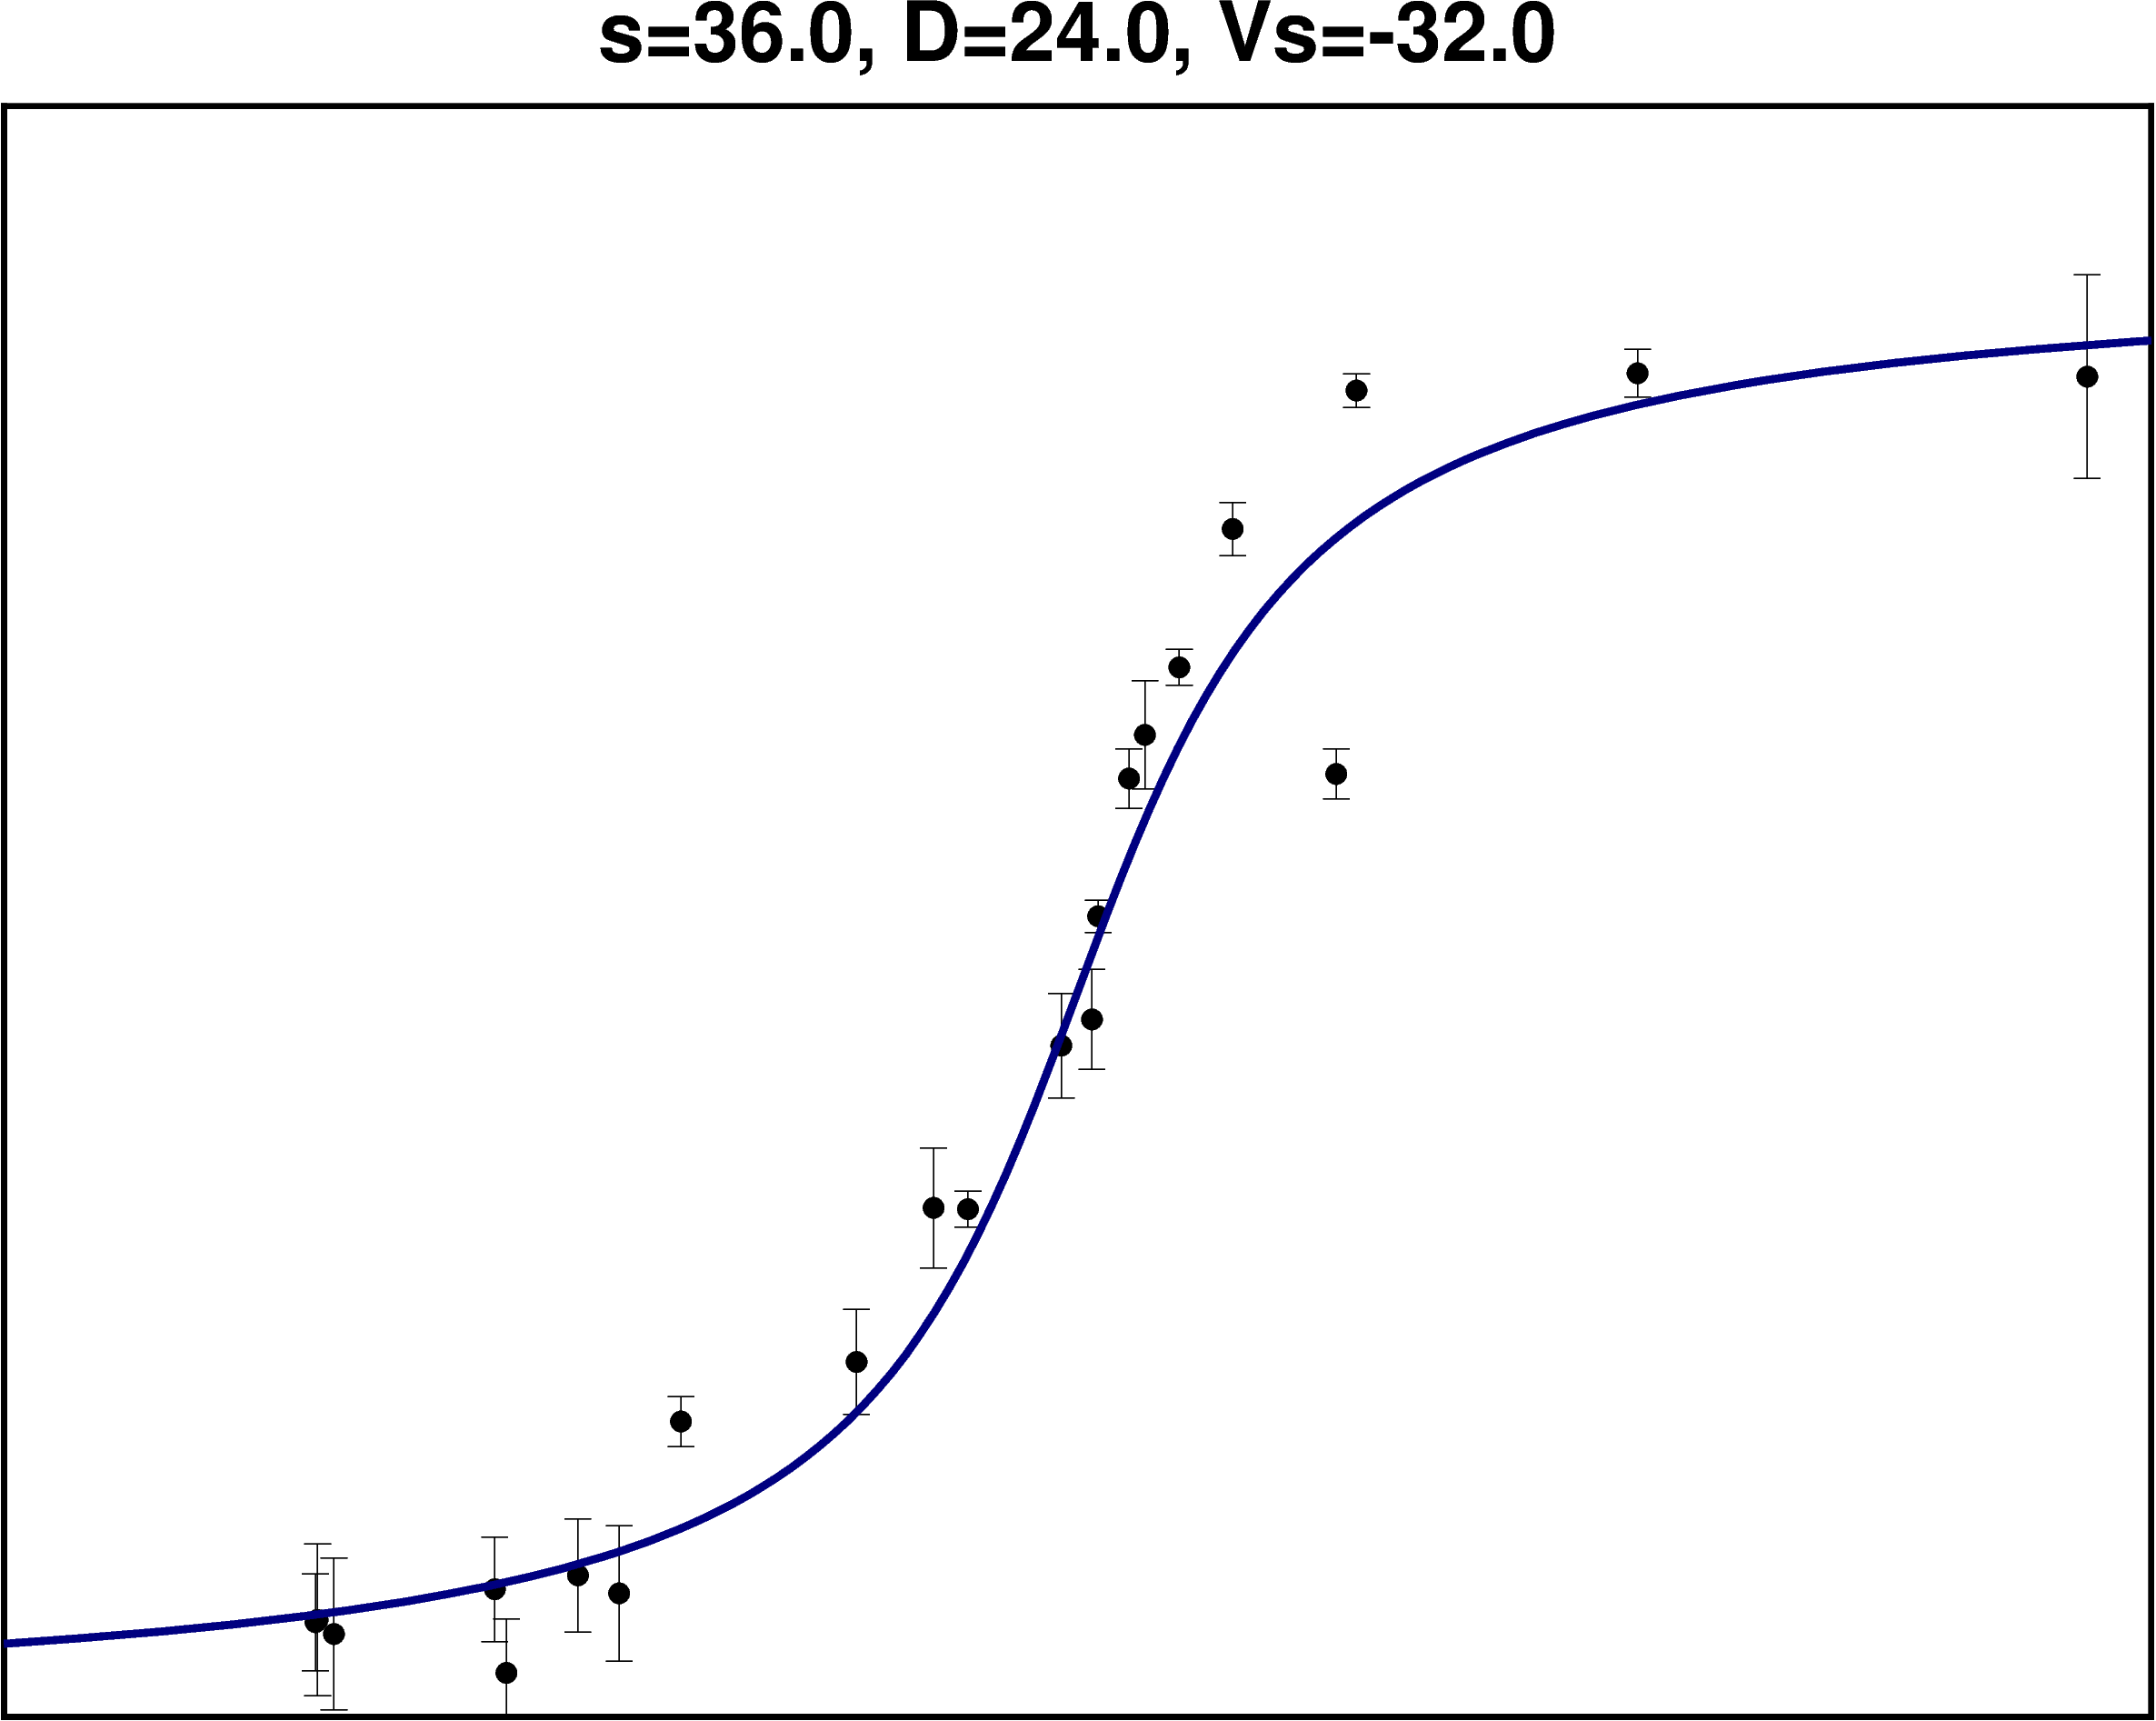

In [246]:
# set minimum and maximum slip rate bounds, plus a step size
smin=20
smax=40
sstep=2

# make a range of possible slip rate values
slip_rates=np.arange(smin,smax+sstep,sstep)
#print(slip_rates)

# set minimum and maximum locking depth bounds, plus a step size
Dmin=10
Dmax=25
Dstep=1

# make a range of possible locking depth values
locking_depths=np.arange(Dmin,Dmax+Dstep,Dstep)
#print(locking_depths)

# set minimum and maximum velocity shift bounds, plus a step size
Vsmin=-35
Vsmax=-28
Vsstep=1

# make a range of possible locking depth values
velocity_shifts=np.arange(Vsmin,Vsmax+Vsstep,Vsstep)
#print(velocity_shifts)

#keep track of the best model
best_s=-9999
best_D=-9999
best_Vs=-9999
best_RSS=1e30

#RSS_array=np.zeros((len(slip_rates),len(locking_depths),len(velocity_shifts)))
#RSS_array=np.empty(((len(slip_rates)-1)(len(locking_depths)-1)(len(velocity_shifts)-1)))
RSS_array=np.empty((len(slip_rates)*len(locking_depths)*len(velocity_shifts),4))
#RSS_array=np.empty((0,0))

#c_s=0
#c_D=0
#c_Vs=0

c=0

# loop through your locking depths to show how it is done

for s in slip_rates:
    for D in locking_depths:
#    for s in slip_rates:
        for Vs in velocity_shifts:
            # Evaluate the model
            model_v=slip1d(s,D,Vs,x_dis[:,2])
            
            # Calculate the RSS penalty
            RSS=np.sum((v_gps-model_v)**2)
#            print(s,D,Vs,RSS)
#            RSS_array[c_s,c_D,c_Vs]=RSS
#            np.append(RSS_array,RSS)

            # Store your array
        
            # RSS_array[c]=RSS
            RSS_array[c,:]= [s,D,Vs,RSS]


            # Debug and print your best model
            
            if RSS<best_RSS:
                best_s=s
                best_D=D
                best_Vs=Vs
                best_RSS=RSS
            
             
            # Incriment your counter
            c+=1
#            c_Vs+=1
#        c_D+=1
#    c_s+=1

print("Best Model: s = {0:f} mm/yr, D = {1:f} km, Vs = {2:f} mm/yr, RSS = {3:f} (mm/yr)^2".format(best_s,best_D,best_Vs,best_RSS)) 

RSS_array_best_vs=RSS_array[RSS_array[:,2]==best_Vs]

x=np.linspace(-150,150,151)
v=slip1d(best_s,best_D,best_Vs,x)

#x=np.linspace(-150,150,151)

#RSS=np.sum((v_gps-model_v)**2)

#plot the points to check
pygmt.config(FONT_ANNOT_PRIMARY="18p")

region = [np.min(x), np.max(x),-50,-10]
fig = pygmt.Figure()
fig.basemap(region=region,projection='X20c/15c',frame='WESn+ts={0:4.1f}, D={1:4.1f}, Vs={2:5.1f}'.format(best_s, best_D, best_Vs))
#fig.plot(data=np.vstack((x_gps,v_gps)).T,style='c0.2',fill='black')
fig.plot(data=np.vstack((x_dis[:,2],v_gps,v_gps_error)).T,style='c0.2',fill='black',error_bar='y')
#fig.plot(data=gps_data,style='c0.1c',fill='black',error_bar='y')
fig.plot(x=x,y=v,pen='2p,navy')
fig.show()


       
        
    #print(D)  # mind you, you probably want to evaluate the model here, and then the misfit, not whatever this is

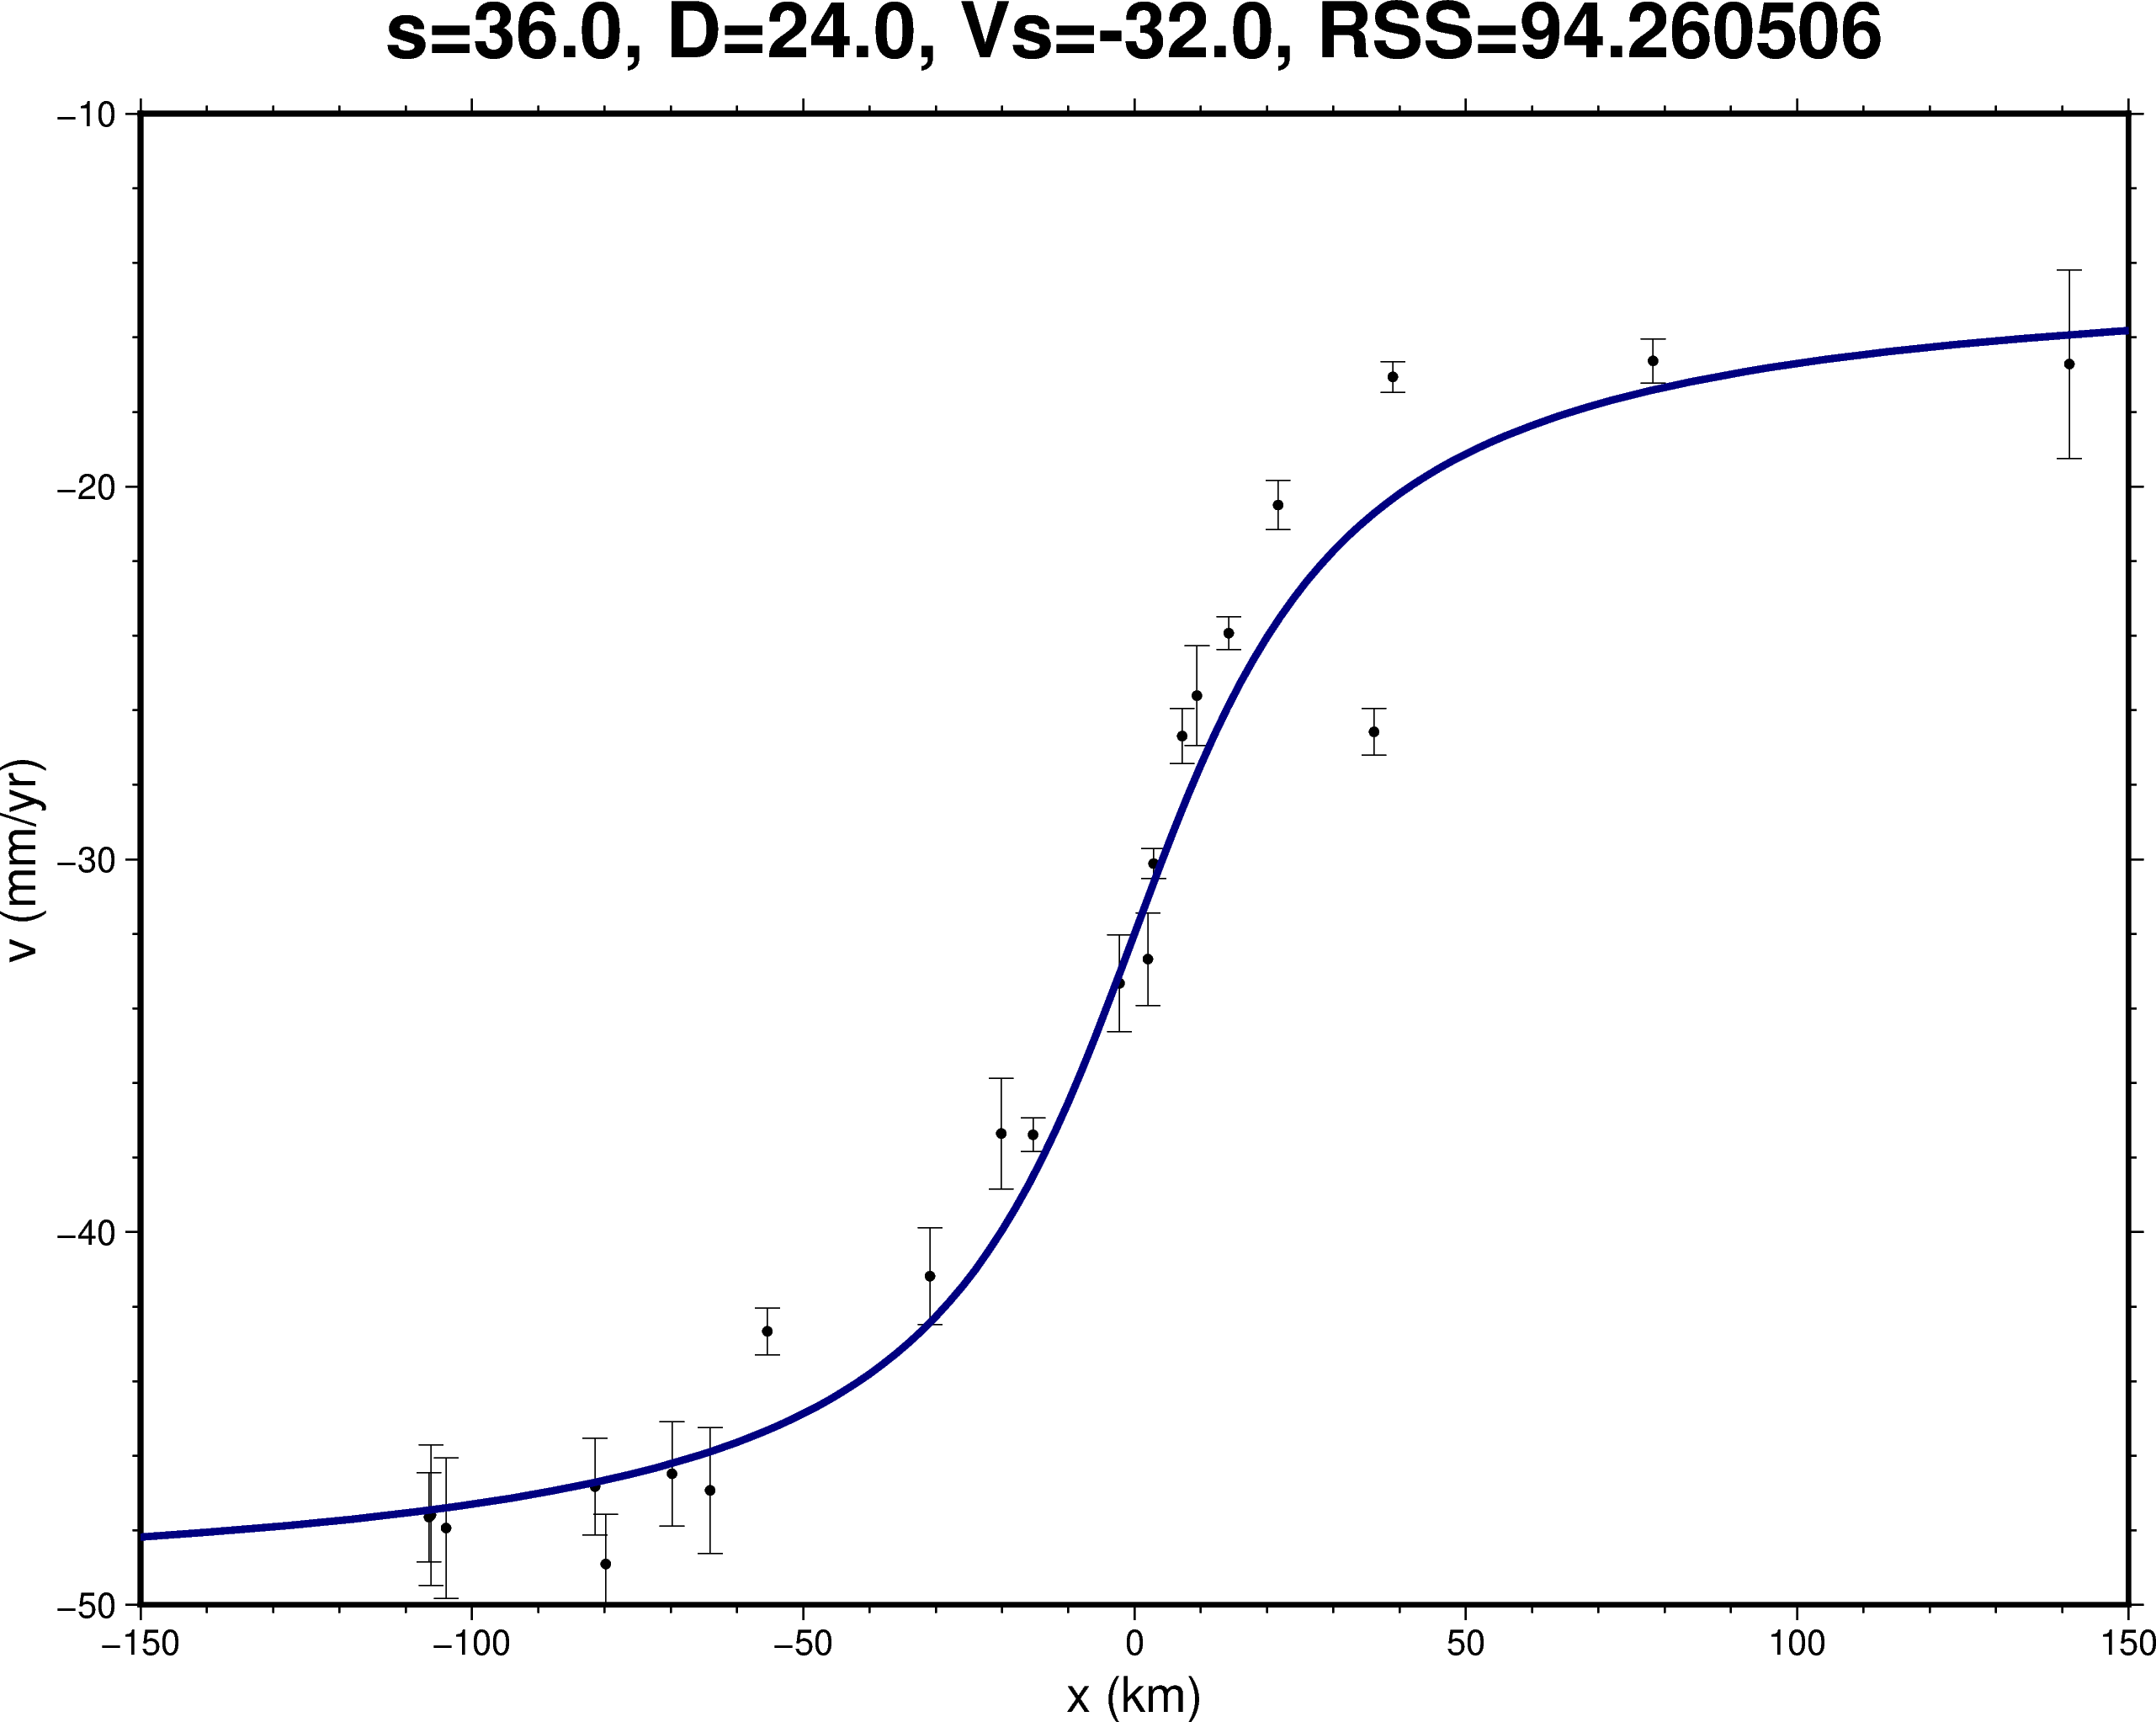

In [205]:
RSS_array_3D=RSS_array.reshape(len(slip_rates),len(locking_depths),len(velocity_shifts))
RSS_array_3D[0,0,:]

RSS_array_3D[:,:,velocity_shifts==best_Vs]

region = [np.min(x), np.max(x),-50,-10]
fig = pygmt.Figure()
fig.basemap(region=region,projection='X20c/15c',frame=['WeSn+ts={0:4.1f}, D={1:4.1f}, Vs={2:5.1f}, RSS={3:f}'.format(best_s,best_D,best_Vs,best_RSS),
                                                       'xa50f10+lx (km)','ya10f2+lv (mm/yr)'])
#fig.plot(data=np.vstack((x_gps,v_gps)).T,style='c0.2',fill='black')
fig.plot(data=np.vstack((x_dis[:,2],v_gps, v_gps_error)).T,style='c0.1',fill='black',error_bar='y')
#fig.plot(data=gps_data,style='c0.1c',fill='black',error_bar='y')
fig.plot(x=x,y=v,pen='2p,navy')
fig.show()


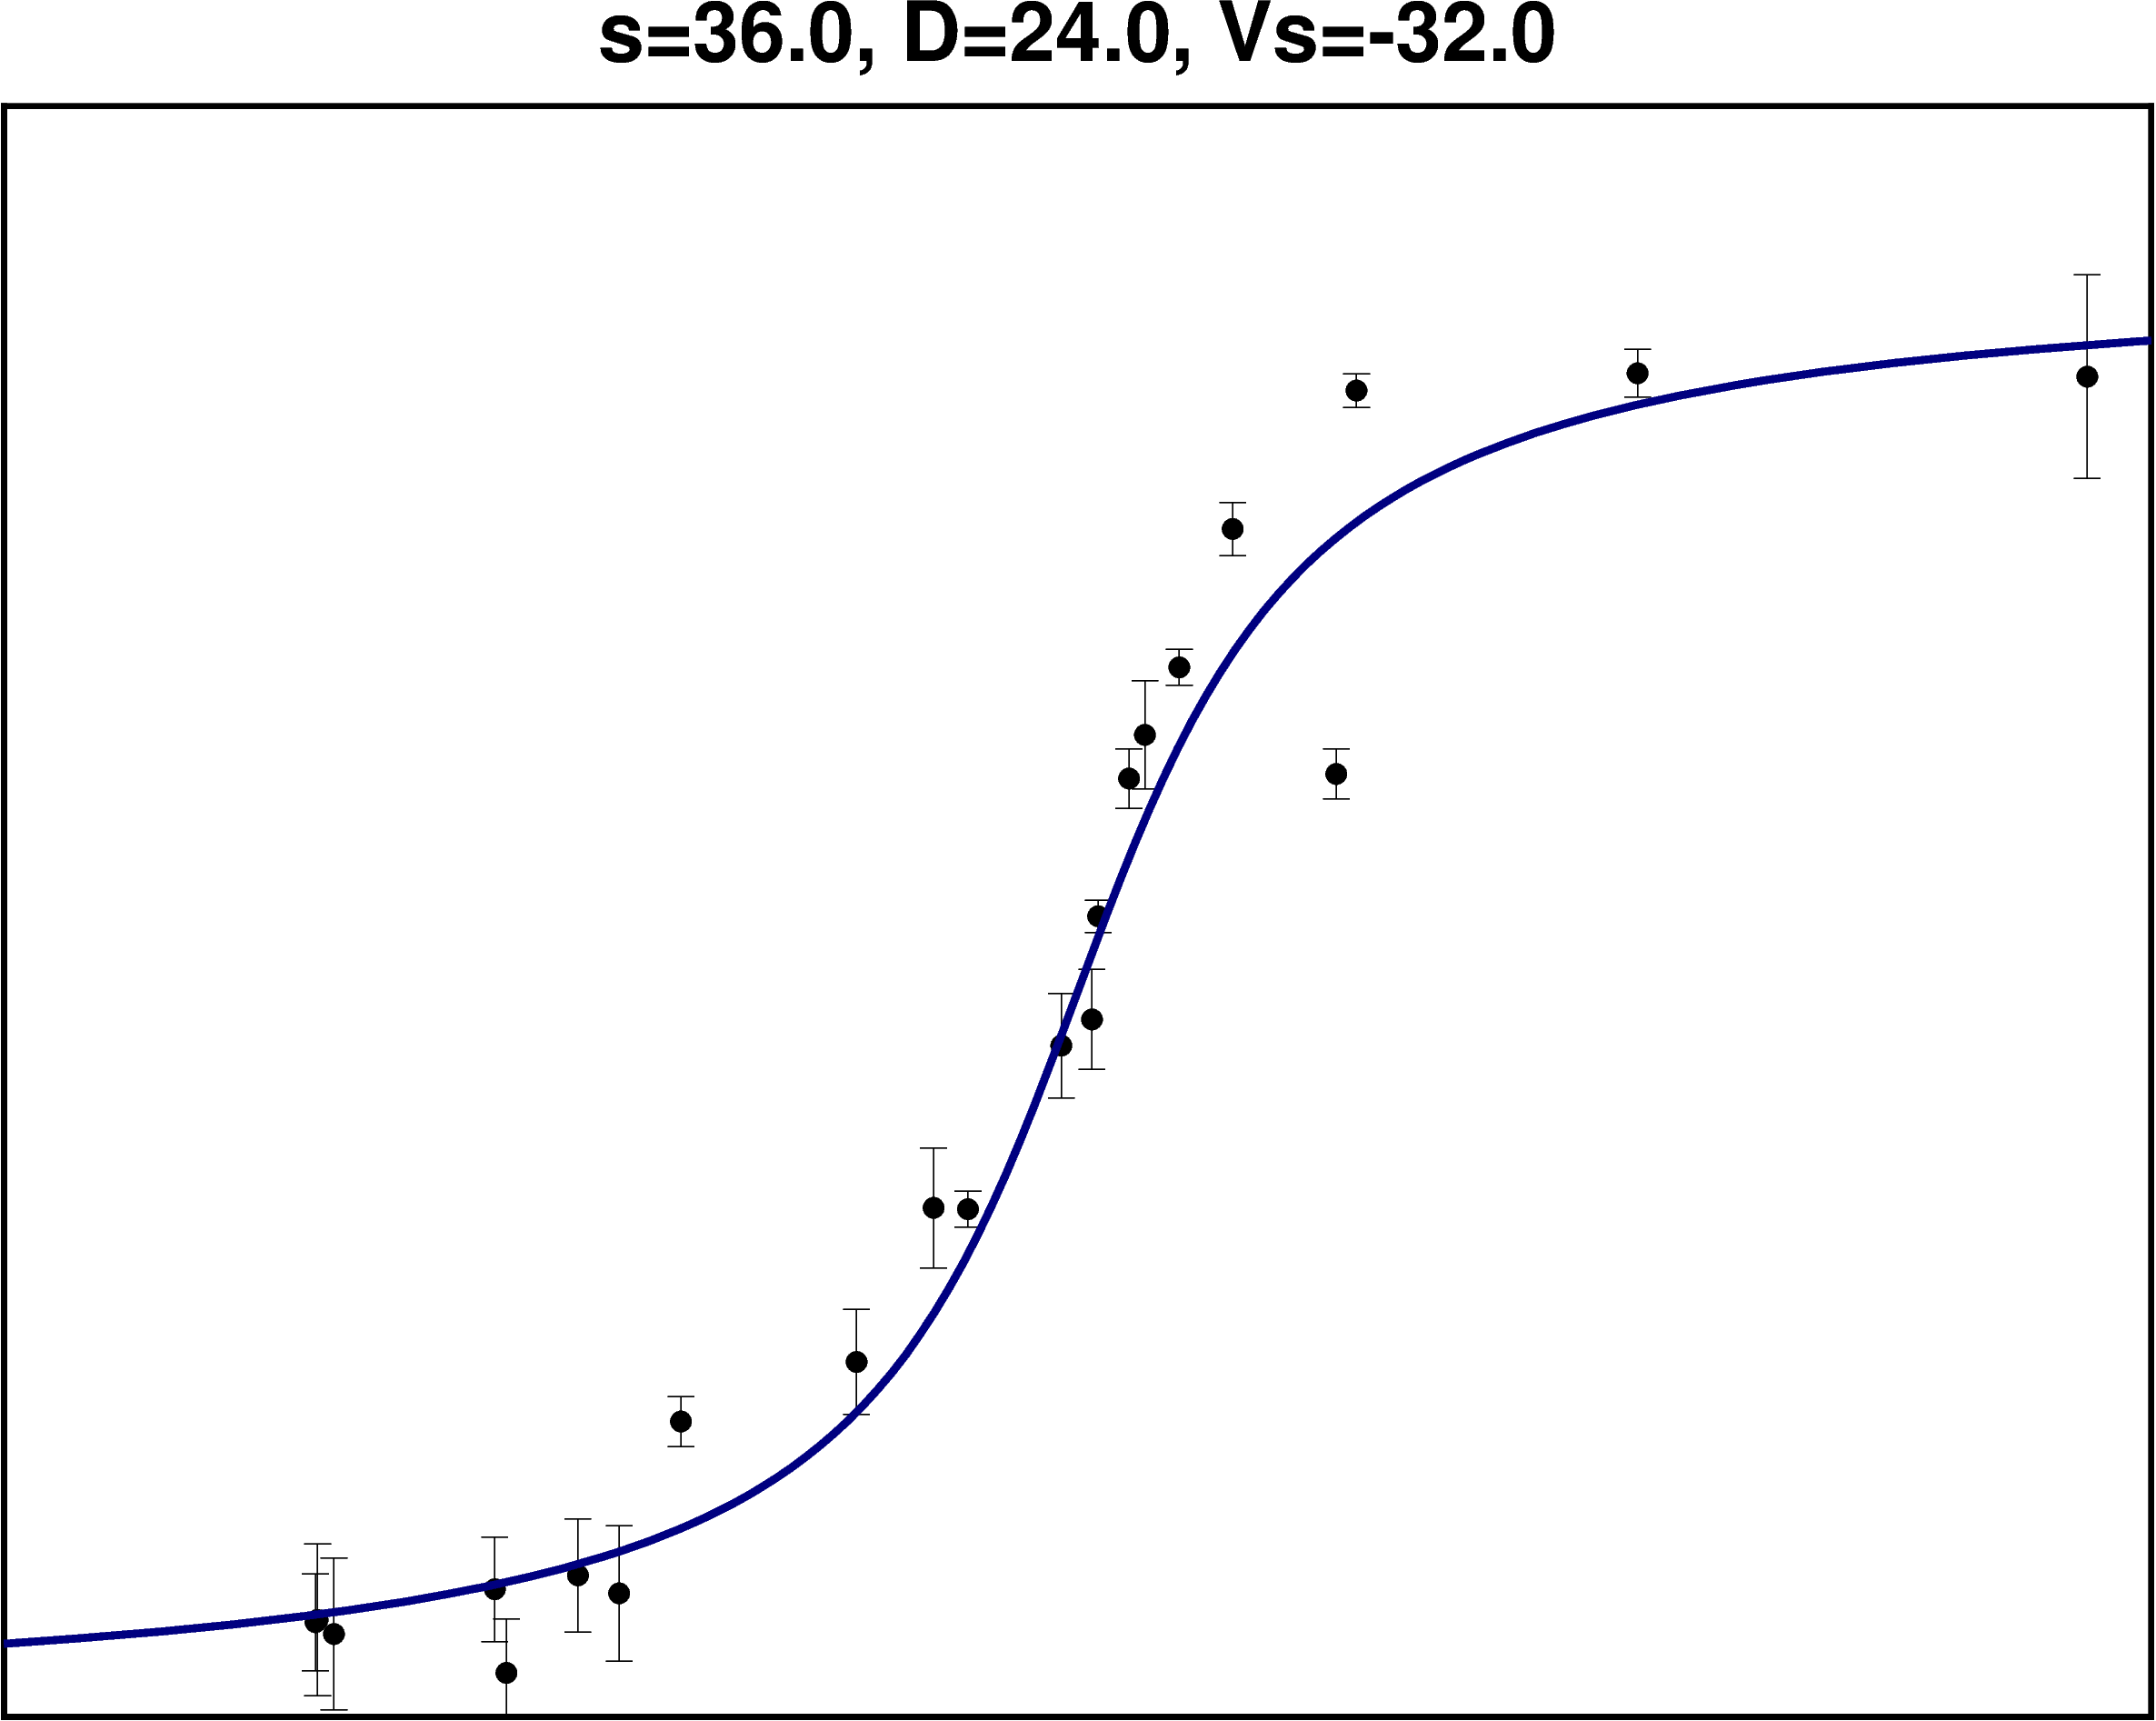

In [228]:










# slip rates and locking depths and penalty function

fig = pygmt.Figure()
fig.basemap(region=region,projection='X20c/15c',frame='WESn+ts={0:4.1f}, D={1:4.1f}, Vs={2:5.1f}'.format(best_s, best_D, best_Vs))
#fig.plot(data=np.vstack((x_gps,v_gps)).T,style='c0.2',fill='black')
fig.plot(data=np.vstack((x_dis[:,2],v_gps,v_gps_error)).T,style='c0.2',fill='black',error_bar='y')
#fig.plot(data=gps_data,style='c0.1c',fill='black',error_bar='y')
fig.plot(x=x,y=v,pen='2p,navy')
fig.show()



In [244]:
RSS_array_3D[0][:][0]

array([507.7139011 , 439.63480543, 415.55570977, 435.47661411,
       499.39751844, 607.31842278, 759.23932712, 955.16023145])

In [257]:
#gps_ass_cpt=pygmt.makecpt(cmap="jet", series=[min(D), max(D), 10])

fig = pygmt.Figure()
region=[np.min(s),np.max(s),np.min(D),np.max(D)]
fig.basemap(region=region, projection='x0.75c',frame=['WeSn+tRSS penalty (mm/yr)^2','xa5f1+lslip rate (mm/year)','ya2f1+llocking depth(km)'])
RSS_array_best_vs
RSS_array_best_vs=RSS_array[RSS_array[:,2]==best_Vs]
fig.contour(data=RSS_array_best_vs[:,(0,1,3)], pen='1p')
# fig.plot(x-)region=region, projection='x0.75c'
fig.show()

#fig.grdcontour(RSS_array_3D, projection=None, frame=True, region=None, verbose=False, panel=False, transparency=None, perspective=False)

basemap [ERROR]: Option -R parsing failure. Correct syntax:



-R<west>/<east>/<south>/<north>[+r]
Specify the min/max coordinates of your data region in user units. Use dd:mm[:ss] for regions
     given in arc degrees, minutes [and seconds]. Use -R<xmin>/<xmax>/<ymin>/<ymax>[+u<unit>] for
     regions given in projected coordinates, with <unit> selected from e|f|k|M|n|u [Default: e]. If
     +u is set, projected regions centered on (0,0) may be set via -R<halfwidth>[/⏎
     …<halfheight>]+u<unit>, where <halfheight> defaults to <halfwidth> if not given. Use
     [yyyy[-mm[-dd]]]T[hh[:mm[:ss[.xxx]]]] format for time axes. Append +r if -R specifies the
     coordinates of the lower left and upper right corners of a rectangular area.
Use -Re and -Ra to set exact or approximate regions based on your input data (if applicable).
     Use -R<gridfile> to use its limits (and increments if applicable). Use -Rg and -Rd as
     shorthand for -R0/360/-90/90 and -R-180/180/-90/90. Derive region from closed polygons from
     the Digital Chart of the World (D

GMTCLibError: Module 'basemap' failed with status code 72:
basemap [ERROR]: Option -R parsing failure. Correct syntax:
basemap [ERROR]: Offending option -R40/40/25/25

In [258]:
print(np.min(s),np.max(s),np.min(D),np.max(D))

40 40 25 25


## References


Savage, J. C., and R. O. Burford (1973), Geodetic determination of relative plate motion in central California, J. Geophys. Res., 78(5), 832–845, [doi:10.1029/JB078i005p00832](https://doi.org/10.1029/JB078i005p00832). 

Schmalzle, G., T. Dixon, R. Malservisi, and R. Govers (2006), Strain accumulation across the Carrizo segment of the San Andreas Fault, California: Impact of laterally varying crustal properties, J. Geophys. Res., 111, B05403, [doi:10.1029/2005JB003843]( https://doi.org/10.1029/2005JB003843).  
